In [162]:
# 1/8/2021
# This notebook trains a CFL model with the visual bars dataset
# and compares the resulting observational partition with ground truth.

In [163]:
# imports
import visual_bars.generate_visual_bars_data as vbd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import sys
from time import sleep
import numpy as np

# cfl imports
sys.path.insert(1, '../../cfl')
from cfl.cluster_methods import kmeans
from cfl.density_estimation_methods import condExpKC
import cfl.core_cfl_objects.two_step_cfl as tscfl
from cfl.util.data_processing import one_hot_encode
from cfl.dataset import Dataset

In [164]:
# generate data

n_samples = 10000
noise_lvl = 0.0
im_shape = (10, 10)
print('Generating a visual bars dataset with {} samples at noise level {}'.format(n_samples, noise_lvl))
sleep(1)
vb_data = vbd.VisualBarsData(n_samples=n_samples, im_shape = im_shape, noise_lvl=noise_lvl)

x = vb_data.getImages()
y = vb_data.getTarget()
 
x = np.expand_dims(x, -1)
y = one_hot_encode(y, unique_labels=[0,1])

Generating a visual bars dataset with 10000 samples at noise level 0.0


In [165]:
data = Dataset(x, y)

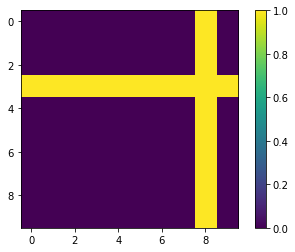

xshapes:  ((8500, 10, 10, 1), (1500, 10, 10, 1))
yshapes:  ((8500, 2), (1500, 2))


In [166]:
# plot an example image

plt.imshow(Xtr[1])
plt.colorbar()
plt.show()

print('xshapes: ', (Xtr.shape, Xts.shape))
print('yshapes: ', (Ytr.shape, Yts.shape))

In [173]:
# parameters for CDE 
lr = 1e-4 # this was 1e-3 in Chalupka's code
condExp_params = {  'batch_size': 32, # this was 10 in Chalupka's code
                    'lr': lr, 
                    'optimizer': 'adam', 
                    'n_epochs': 3, 
                    # 'standardize': True
                 }
data_info = {'X_dims': x.shape, 
             'Y_dims': y.shape, 
             'Y_type': 'categorical'}

# generate CDE object
condExp_object = condExpKC.CondExpKC(data_info, condExp_params)

lr specified but not used by CondExpKC clusterer
opt_config not specified in input, defaulting to {}
verbose not specified in input, defaulting to 1
dense_units not specified in input, defaulting to [50, 2]
activations not specified in input, defaulting to ['relu', 'linear']
dropouts not specified in input, defaulting to [0, 0]
weights_path not specified in input, defaulting to None
loss not specified in input, defaulting to mean_squared_error
show_plot not specified in input, defaulting to True
name not specified in input, defaulting to CondExpKC
standardize not specified in input, defaulting to False
best not specified in input, defaulting to True


In [176]:
# generate clusterer 
cluster_params = {'n_Xclusters':4, 'n_Yclusters':2}
cluster_object = kmeans.KMeans('Kmeans', data_info, cluster_params)

In [169]:
# # put into a cfl core object 
# cfl_object = tscfl.Two_Step_CFL_Core(condExp_object, cluster_object)

Train on 7500 samples, validate on 2500 samples
Epoch 1/3
7500/7500 [==============================] - 5s 605us/sample - loss: 0.1724 - val_loss: 0.1474
Epoch 2/3
7500/7500 [==============================] - 1s 141us/sample - loss: 0.1403 - val_loss: 0.1438
Epoch 3/3
7500/7500 [==============================] - 1s 197us/sample - loss: 0.1387 - val_loss: 0.1448


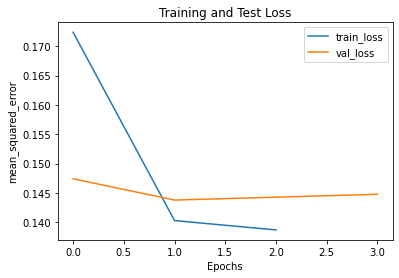

{'train_loss': [0.17237726697127023, 0.14029120621681213, 0.13870300244092942],
 'val_loss': [0.1474147373020649, 0.14378715229034425, 0.1447722257643938],
 'loss_plot': <Figure size 432x288 with 1 Axes>,
 'model_weights': [array([[-0.01951578, -0.09393861,  0.08969493, ...,  0.15366429,
           0.00605302, -0.11514858],
         [-0.16837071,  0.23982725,  0.00914114, ..., -0.12547736,
           0.2287326 , -0.12440003],
         [-0.01431935,  0.05025387,  0.0032071 , ..., -0.10496316,
           0.12950124, -0.08907945],
         ...,
         [-0.1884204 ,  0.06825446, -0.07478534, ...,  0.07912966,
           0.06313283, -0.12604825],
         [ 0.04421705,  0.06548553, -0.03802872, ...,  0.04851241,
           0.10927945,  0.1150496 ],
         [-0.18488984,  0.16263442, -0.18044128, ...,  0.20728722,
           0.05064333,  0.13973126]], dtype=float32),
  array([-0.04761655, -0.04622559,  0.14801073, -0.04503193, -0.06284943,
         -0.04259617,  0.04996366,  0.23277949,  

In [177]:
condExp_object.train(data)

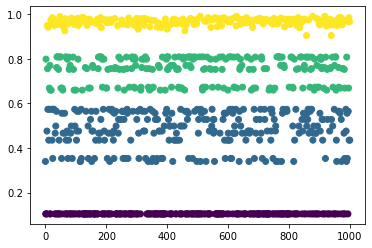

Average prediction for x-class 0: 0.10
Average prediction for x-class 1: 0.48
Average prediction for x-class 2: 0.74
Average prediction for x-class 3: 0.97


In [178]:
# before clustering, we can look at the distribution of CDE outputs
results_dict = condExp_object.predict(data)
pyx = results_dict['pyx']
truth = vb_data.getGroundTruth()
plot_idx = np.random.choice(pyx.shape[0], 1000, replace=False)
plt.scatter(range(1000), pyx[plot_idx,1], c=truth[plot_idx])
plt.show()

for i in range(4):
    print('Average prediction for x-class {}: {:.2f}'.format(i, np.mean(pyx[truth==i,1])))

In [179]:
# generate cluster
cluster_object.train(data, results_dict)
clusters = cluster_object.predict(data, results_dict)

# rand_score
print('Rand score: ', adjusted_rand_score(truth, clusters['x_lbls']))

Rand score:  1.0


In [174]:
# calculate comparison with ground truth by hand
print(clusters['x_lbls'][:20])
print(truth[:20])

[1 1 2 1 0 0 3 3 0 3 2 1 1 1 3 2 0 1 0 1]
[0 0 3 0 1 1 1 1 2 1 3 0 0 0 1 3 2 0 1 0]


In [175]:
x_lbls_all = clusters['x_lbls']

accuracy = 0
for i in range(len(x_lbls_all)):
    if (x_lbls_all[i]==0) & (truth[i]==1):
        accuracy +=1
    elif(x_lbls_all[i]==1) & (truth[i]==3):
        accuracy +=1
    elif(x_lbls_all[i]==2) & (truth[i]==0):
        accuracy +=1
    elif(x_lbls_all[i]==3) & (truth[i]==2):
        accuracy +=1
        
print("Accuracy: ", accuracy/len(truth))

Accuracy:  0.1761
